<a href="https://colab.research.google.com/github/rpdahxn/CV_PaperReview/blob/main/02GerativeAdversarialNets/GAN_celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("cuda : ", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

cuda :  Tesla K80


device(type='cuda')

데이터 불러오기

In [4]:
def crop_centre(img, new_width, new_height):
  height, width, _ = img.shape
  startx = width//2 - new_width//2
  starty = height//2 - new_height//2
  return img[starty:starty + new_height, startx:startx + new_width, :]

In [5]:
class CelebADataset(Dataset):

  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if (index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index) + '.jpg'])
    # 128x128로 크롭
    img = crop_centre(img, 128, 128)
    return torch.cuda.FloatTensor(img).permute(2, 0, 1).view(1, 3, 128, 128) / 255.0


  def plot_image(self, index):
    img = numpy.array(self.dataset[str(index) + '.jpg'])
    img = crop_centre(img, 128, 128)
    plt.imshow(img, interpolation = 'nearest')
    pass

  pass

In [6]:
celeba_dataset = CelebADataset('/content/mount/MyDrive/Colab Notebooks/celeba_dataset/celeba_aligned_small.h5py')

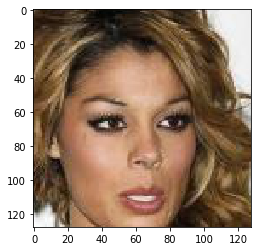

In [7]:
celeba_dataset.plot_image(5)

**판별기**

In [8]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

In [9]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Conv2d(3, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 3, kernel_size = 8, stride = 2),
        nn.LeakyReLU(0.2),

        View(3*10*10),
        nn.Linear(3*10*10, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass


  def forward(self, inputs):
    return self.model(inputs)


  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
    if (self.counter % 1000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()


  def plot_progress(self):
      df = pandas.DataFrame(self.progress, columns=['loss'])
      df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
      pass
      
  pass

판별기 테스트

In [10]:
def generate_random_image(size):
  return torch.rand(size)

In [ ]:
D = Discriminator()
D.to(device)

for image_data in celeba_dataset:
  D.train(image_data, torch.cuda.FloatTensor([1.0]))
  D.train(generate_random_image((1, 3, 128, 128)), torch.cuda.FloatTensor([0.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000


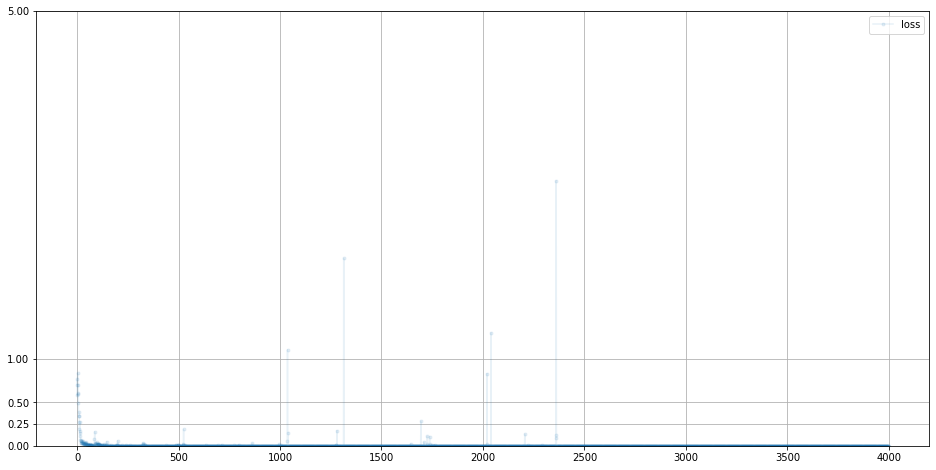

In [ ]:
D.plot_progress()

In [ ]:
for i in range(5):
  image_tensor = celeba_dataset[random.randint(0, 20000)]
  print(D.forward(image_tensor).item())
  pass

for i in range(5):
  print(D.forward(generate_random_image((1, 3, 128, 128))).item())
  pass

1.0
1.0
1.0
1.0
1.0
5.4869538246293814e-08
1.5272077291683672e-07
7.323023520910965e-09
1.126368402992739e-07
2.4115500707466708e-08


**생성기**

In [11]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        # 입력은 1차원 행렬
        nn.Linear(100, 3*11*11),
        nn.LeakyReLU(0.2),

        # 4차원으로 변환
        View((1, 3, 11, 11)),

        nn.ConvTranspose2d(3, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(256, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(256, 3, kernel_size = 8, stride = 2, padding = 1),
        nn.BatchNorm2d(3),

        # 출력 형태 (1, 3, 128, 128)
        nn.Sigmoid()
    ) 


    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass


  def forward(self, inputs):
    return self.model(inputs)


  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

  
  pass

In [12]:
def generate_random_seed(size):
  return torch.randn(size)

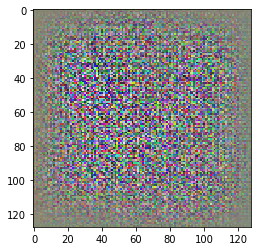

In [ ]:
# 생성기 결과 확인

G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()

plt.imshow(img, interpolation = 'none', cmap = 'Blues')

**GAN훈련**

In [ ]:
%%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 1

for epoch in range(epochs):
  print("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 31min 28s, sys: 9.31 s, total: 31min 37s
Wall time: 31min 36s


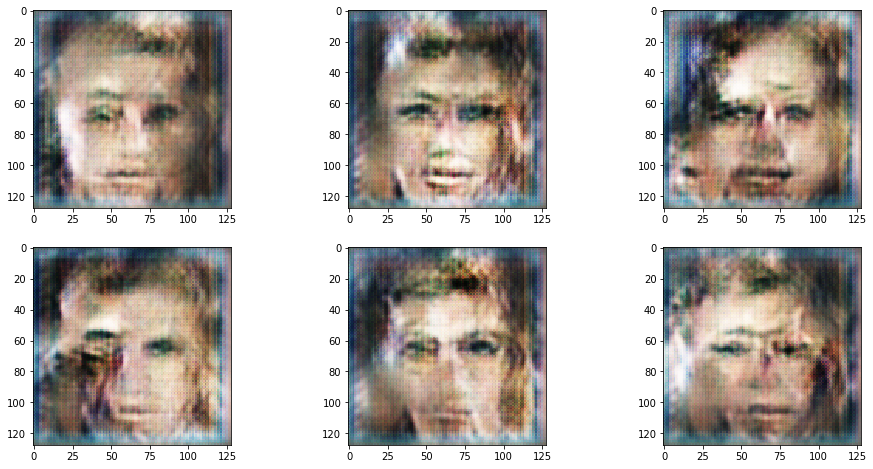

In [ ]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
    axarr[i, j].imshow(img, interpolation = 'none', cmap = 'Blues')
    pass

  pass

In [13]:
%%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 3

for epoch in range(epochs):
  print("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

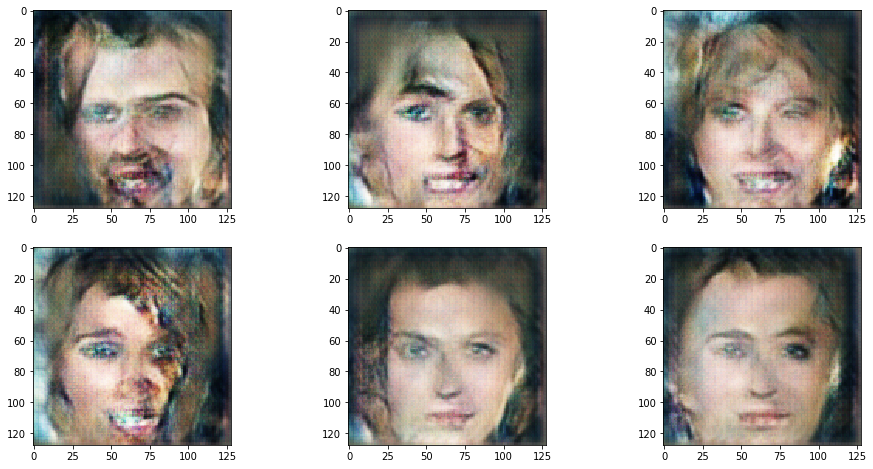

In [14]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
    axarr[i, j].imshow(img, interpolation = 'none', cmap = 'Blues')
    pass

  pass

In [ ]:
%%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 10

for epoch in range(epochs):
  print("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

pass

In [ ]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
    axarr[i, j].imshow(img, interpolation = 'none', cmap = 'Blues')
    pass

  pass